# CONVOLUTIONAL NEURAL NETWORK
  * type of neural network, developed to improve the accuracy
  * basic principle behind the working of CNN is the idea of convolution, producing feature maps using filters
  
### WHY CONVOLUTION?
Multi-layer neural networks can perform pretty well in predicting simple images, but for more complicated, like RGB pictures we would need to increase the number of layers in our neural network to make it deeper. However, it will come at a cost – the number of parameters (i.e. weights and biases) will rapidly increase. This makes the model more prone to overfitting and will prolong training times. 

Translation invariance


In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt

#### 1. DATASET
  * MNIST dataset of handwritten images, 28x28, grayscale

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
print("Size of:")
print("- Training set:\t\t{}".format(len(data.train.labels)))
print("- Test set:\t\t{}".format(len(data.test.labels)))
print("- Validation set:\t{}".format(len(data.validation.labels)))

Size of:
- Training set:		55000
- Test set:		10000
- Validation set:	5000


### BUILDING CNN

#### 2. CONVOLUTIONAL LAYER + RELU
Primary purpose: 
  * extract features from input image

The convolutional layer consist of a set of learnable filters. Filters are used for recognizing patterns throughout the entire input image. Convolution works by sliding the filter over the input image and along the way we take the dot product between the filter and chunks of the input image.

We also apply Rectified Linear Unit (replaces all negative values to zero) to introduce non linearity in our CNN. We could also apply tanh or sigmoid function but ReLU performs better in most cases. 

Back to translation invariance:
  * filter for identifying dog in the image -> positive numbers when filter "sees" the dog, and negative otherwise
  * it will identify dog no matter where is it on the picture


In [5]:
def convolutional_layer(input, num_input_channels, filter_size, num_filters, name):  
    # Shape of the filter-weights for the convolution
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights (filters) with the given shape
    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.03), name=name+'_w')

    # Create new biases, one for each filter
    biases = tf.Variable(tf.truncated_normal([num_filters]), name=name+'_b')

    # TensorFlow operation for convolution
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')

    # Add the biases to the results of the convolution.
    layer += biases
    
    # relu
    layer = tf.nn.relu(layer)

    return layer, weights

#### 3. POOL LAYER
Pooling layer reduces the size of feature maps by taking the average or the maximum value. The purpose of pooling is to reduce the number of parameters in our network and to make learned features more robust by making it more invariant to scale and orientation changes.

In [6]:
def pool_layer(input):
    layer = tf.nn.max_pool(value=input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    return layer

#### 5. FULLY CONNECTED LAYER
A fully connected layer takes all neurons in the previous layer and connects it to every single neuron in next layer. Adding a fully-connected layer is also a cheap way of learning non-linear combinations of these features. Most of the features learned from convolutional and pooling layers may be good, but combinations of those features might be even better.

In [7]:
def fully_connected_layer(input, num_inputs, num_outputs, name):

        # Create new weights and biases.
        weights = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.03), name=name+'_w')
        biases = tf.Variable(tf.truncated_normal([num_outputs], stddev=0.01), name=name+'_b')
        
        # Multiply the input and weights, and then add the bias-values.
        layer = tf.matmul(input, weights) + biases
        
        return layer

### NETWORK ARHITECTURE
  * Convolution, 6 x filter of shape [5, 5] 
  * Max pooling of size [2, 2]
  * Convolution, 16 x filter of shape [5,5] 
  * Max pooling of size [2, 2] 
  * Fully Connected Layer with 128 nodes in hidden layer
  * ReLU
  * Fully Connected Layer with 10 output nodes (digits 0-9)
  * Softmax


#### 6. TENSORFLOW SESSION

In [9]:
# Placeholder variable for the input images
x = tf.placeholder(tf.float32, shape=[None, 28*28], name='X')

# Reshape it into [num_images, img_height, img_width, num_channels]
x_image = tf.reshape(x, [-1, 28, 28, 1])

# Placeholder variable for the true labels associated with the images
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [10]:
# Convolutional Layer 1 
layer_conv1, weights_conv1 = convolutional_layer(input=x_image, num_input_channels=1, filter_size=5, num_filters=6, name ="conv1")

# Pooling Layer 1
layer_pool1 = pool_layer(layer_conv1)

# Convolutional Layer 2
layer_conv2, weights_conv2 = convolutional_layer(input=layer_pool1, num_input_channels=6, filter_size=5, num_filters=16, name= "conv2")

# Pooling Layer 2
layer_pool2 = pool_layer(layer_conv2)

# Flattening
num_features = layer_pool2.get_shape()[1:4].num_elements()
layer_flat = tf.reshape(layer_pool2, [-1, num_features])

# Fully-Connected Layer 1
layer_fc1 = fully_connected_layer(layer_flat, num_inputs=num_features, num_outputs=128, name="fc1")

# RelU
layer_fc1 = tf.nn.relu(layer_fc1)

# Fully-Connected Layer 2
layer_fc2 = fully_connected_layer(input=layer_fc1, num_inputs=128, num_outputs=10, name="fc2")

In [11]:
# Use Softmax function 
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [13]:
# Use Cross entropy cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

In [14]:
# Use Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [15]:
# Accuracy
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [16]:
num_epochs = 100
batch_size = 32
all_costs = []
validation_accuracy = []

In [17]:
with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Loop over number of epochs
    for epoch in range(num_epochs+1):
        
        start_time = time.time()
        avg_cost = 0
        total_batch = int(len(data.train.labels) / batch_size)
        for batch in range(total_batch):
             # Get a batch of images and labels
            x_batch, y_true_batch = data.train.next_batch(batch_size)
            
            # Put the batch into a dict with the proper names for placeholder variables
            feed_dict_train = {x: x_batch, y_true: y_true_batch}
            
            # Train model using optimizer and calculate cost
            _ , cost_ = sess.run([optimizer, cost], feed_dict=feed_dict_train)
            avg_cost += cost_ / total_batch
        
        all_costs.append(avg_cost) 
        
        train_accuracy = sess.run(accuracy, feed_dict={x: data.train.images, y_true: data.train.labels})        
        # Validate the model on the entire validation set
        vali_accuracy = sess.run(accuracy, feed_dict={x: data.validation.images, y_true: data.validation.labels})
        validation_accuracy.append(vali_accuracy)
        end_time = time.time()

        print("Epoch "+str(epoch+1)+" completed : Time usage "+str(int(end_time-start_time))+" seconds")
        print("Cost =", "{:.3f}".format(avg_cost))
        print("\tAccuracy:")
        print("\t- Training Accuracy:\t{}".format(train_accuracy))
        print("\t- Validation Accuracy:\t{}".format(vali_accuracy))
        
        
    print("Test accuracy")
    print(sess.run(accuracy, feed_dict={x: data.test.images, y_true: data.test.labels}))

Epoch 1 completed : Time usage 97 seconds
Cost = 1.132
	Accuracy:
	- Training Accuracy:	0.8983454704284668
	- Validation Accuracy:	0.9056000113487244
Epoch 2 completed : Time usage 134 seconds
Cost = 0.291
	Accuracy:
	- Training Accuracy:	0.9192909002304077
	- Validation Accuracy:	0.9204000234603882
Epoch 3 completed : Time usage 92 seconds
Cost = 0.236
	Accuracy:
	- Training Accuracy:	0.9345090985298157
	- Validation Accuracy:	0.9355999827384949
Epoch 4 completed : Time usage 93 seconds
Cost = 0.204
	Accuracy:
	- Training Accuracy:	0.943363606929779
	- Validation Accuracy:	0.946399986743927
Epoch 5 completed : Time usage 94 seconds
Cost = 0.178
	Accuracy:
	- Training Accuracy:	0.9488000273704529
	- Validation Accuracy:	0.9480000138282776
Epoch 6 completed : Time usage 94 seconds
Cost = 0.159
	Accuracy:
	- Training Accuracy:	0.9523272514343262
	- Validation Accuracy:	0.9534000158309937
Epoch 7 completed : Time usage 95 seconds
Cost = 0.144
	Accuracy:
	- Training Accuracy:	0.95845454931

Epoch 56 completed : Time usage 91 seconds
Cost = 0.015
	Accuracy:
	- Training Accuracy:	0.9967454671859741
	- Validation Accuracy:	0.9883999824523926
Epoch 57 completed : Time usage 94 seconds
Cost = 0.014
	Accuracy:
	- Training Accuracy:	0.9965272545814514
	- Validation Accuracy:	0.9879999756813049
Epoch 58 completed : Time usage 98 seconds
Cost = 0.014
	Accuracy:
	- Training Accuracy:	0.9952909350395203
	- Validation Accuracy:	0.9868000149726868
Epoch 59 completed : Time usage 92 seconds
Cost = 0.013
	Accuracy:
	- Training Accuracy:	0.9943636655807495
	- Validation Accuracy:	0.9855999946594238
Epoch 60 completed : Time usage 94 seconds
Cost = 0.013
	Accuracy:
	- Training Accuracy:	0.9974908828735352
	- Validation Accuracy:	0.9890000224113464
Epoch 61 completed : Time usage 90 seconds
Cost = 0.012
	Accuracy:
	- Training Accuracy:	0.9973636269569397
	- Validation Accuracy:	0.9876000285148621
Epoch 62 completed : Time usage 92 seconds
Cost = 0.012
	Accuracy:
	- Training Accuracy:	0.997

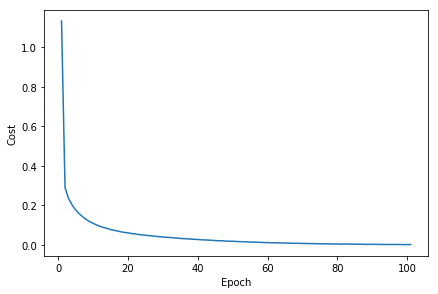

In [18]:
plt.plot(range(1, len(all_costs) + 1), all_costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

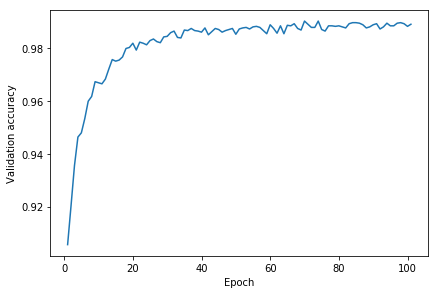

In [19]:
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.show()